In [1]:
%load_ext autoreload
%autoreload 2

**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from skimage import io
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from csbdeep.utils import Path, normalize_mi_ma

In [3]:
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

2025-02-12 12:23:12.340643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-12 12:23:13.899168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-12 12:23:13.911308: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 12:23:15.786369: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-12 12:23:44.934210: W tensorflow/com

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [4]:
X = sorted(glob('/hpc/group/yizhanglab/zs144/Zion-ZhangLab/experiments/EXP004/output/240819_Ji_N1_H_EScan/patches_2048/*.png'))
Y = sorted(glob('/hpc/group/yizhanglab/zs144/Zion-ZhangLab/experiments/EXP004/output/240819_Ji_N1_H_EScan/pseudo_gt_masks_2048/*.png'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [5]:
# X = X[:80]
# Y = Y[:80]

In [6]:
X = [io.imread(x) for x in X]
Y = [io.imread(y) for y in Y]
Y = [(mask // 255).astype(np.uint8) for mask in Y]
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

Normalize images and fill small label holes.

In [7]:
axis_norm = (0,1) # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize_mi_ma(x, 0, 255) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]
# resize image
target_size = (256, 256)
X = [resize(x, target_size, anti_aliasing=False).astype(np.float32) for x in tqdm(X)]
Y = [(resize(y, target_size, anti_aliasing=False) > 0).astype(np.uint8) for y in tqdm(Y)]

Normalizing image channels independently.


100%|██████████| 106/106 [00:10<00:00, 10.53it/s]


Split into train and validation datasets.

In [8]:
assert len(X) > 1, "not enough training data"
X_trn, X_test, Y_trn, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_test))

number of images: 106
- training:        90
- validation:      16


Training data consists of pairs of input image and label instances.

In [9]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img)
    ai.set_title(img_title)
    al.imshow(lbl * 255, cmap='gray')
    al.set_title(lbl_title)
    plt.tight_layout()

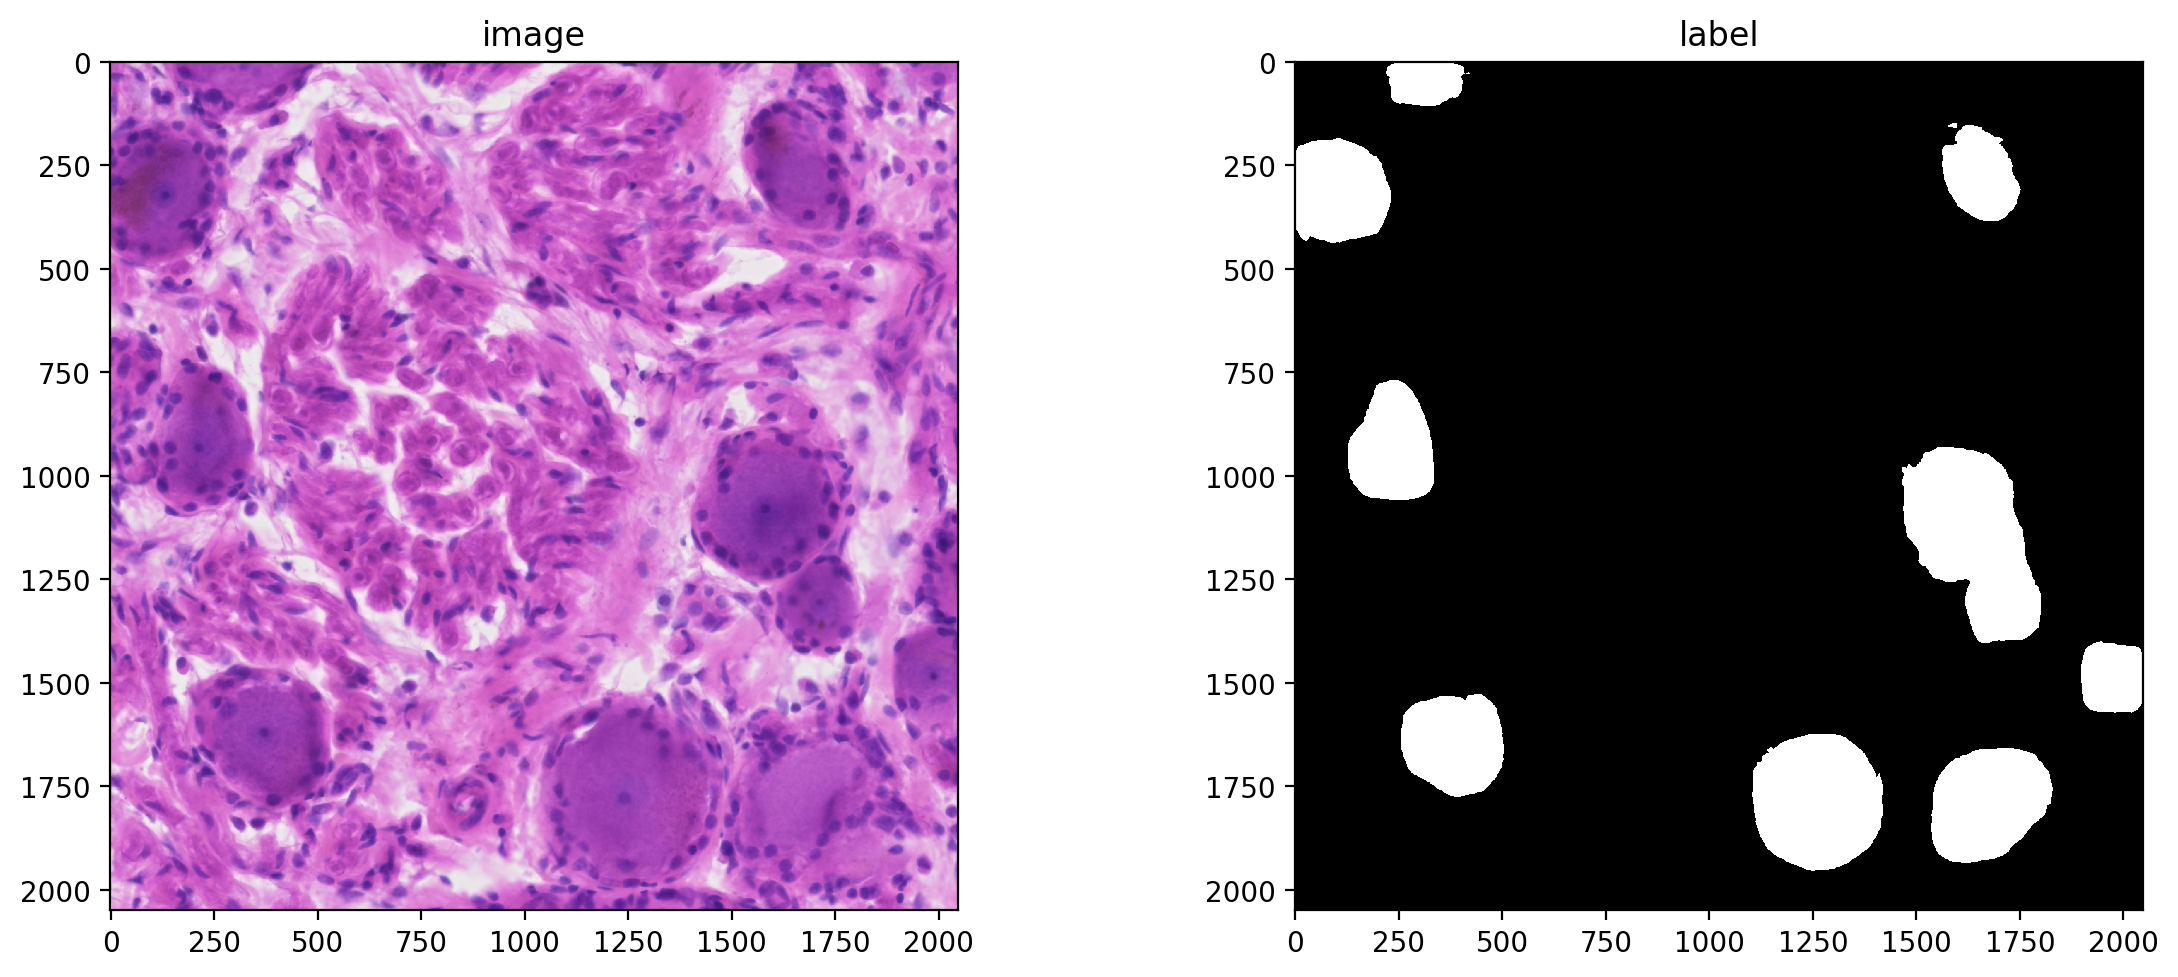

In [10]:
i = 0
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [11]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class prediction (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [12]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True # False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    n_classes    = 1,
    train_patch_size = (256, 256),
    train_batch_size = 4,
    train_learning_rate = 3e-4
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=1, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2, 1), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': 1,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2, 1),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [13]:
# if use_gpu:
#     from csbdeep.utils.tf import limit_gpu_memory
#     # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
#     limit_gpu_memory(0.8)
#     # alternatively, try this:
#     # limit_gpu_memory(None, allow_growth=True)

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [14]:
model = StarDist2D(conf, name='stardist', basedir='models')

2025-02-12 12:29:08.145145: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-12 12:29:12.770163: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-12 12:29:12.773769: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [15]:
model.__dict__

{'config': Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=1, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2, 1), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_d

Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [16]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
I0000 00:00:1739381360.949570  949727 service.cc:145] XLA service 0x7f24b0005860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739381360.949609  949727 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-02-12 12:29:21.457286: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-12 12:29:22.223951: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


median object size:      [1610.5 1775. ]
network field of view :  [94 94]


I0000 00:00:1739381373.339827  949727 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [24]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0755618926249715..1.0058354419283277].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07815487988606203..1.0181939487778517].


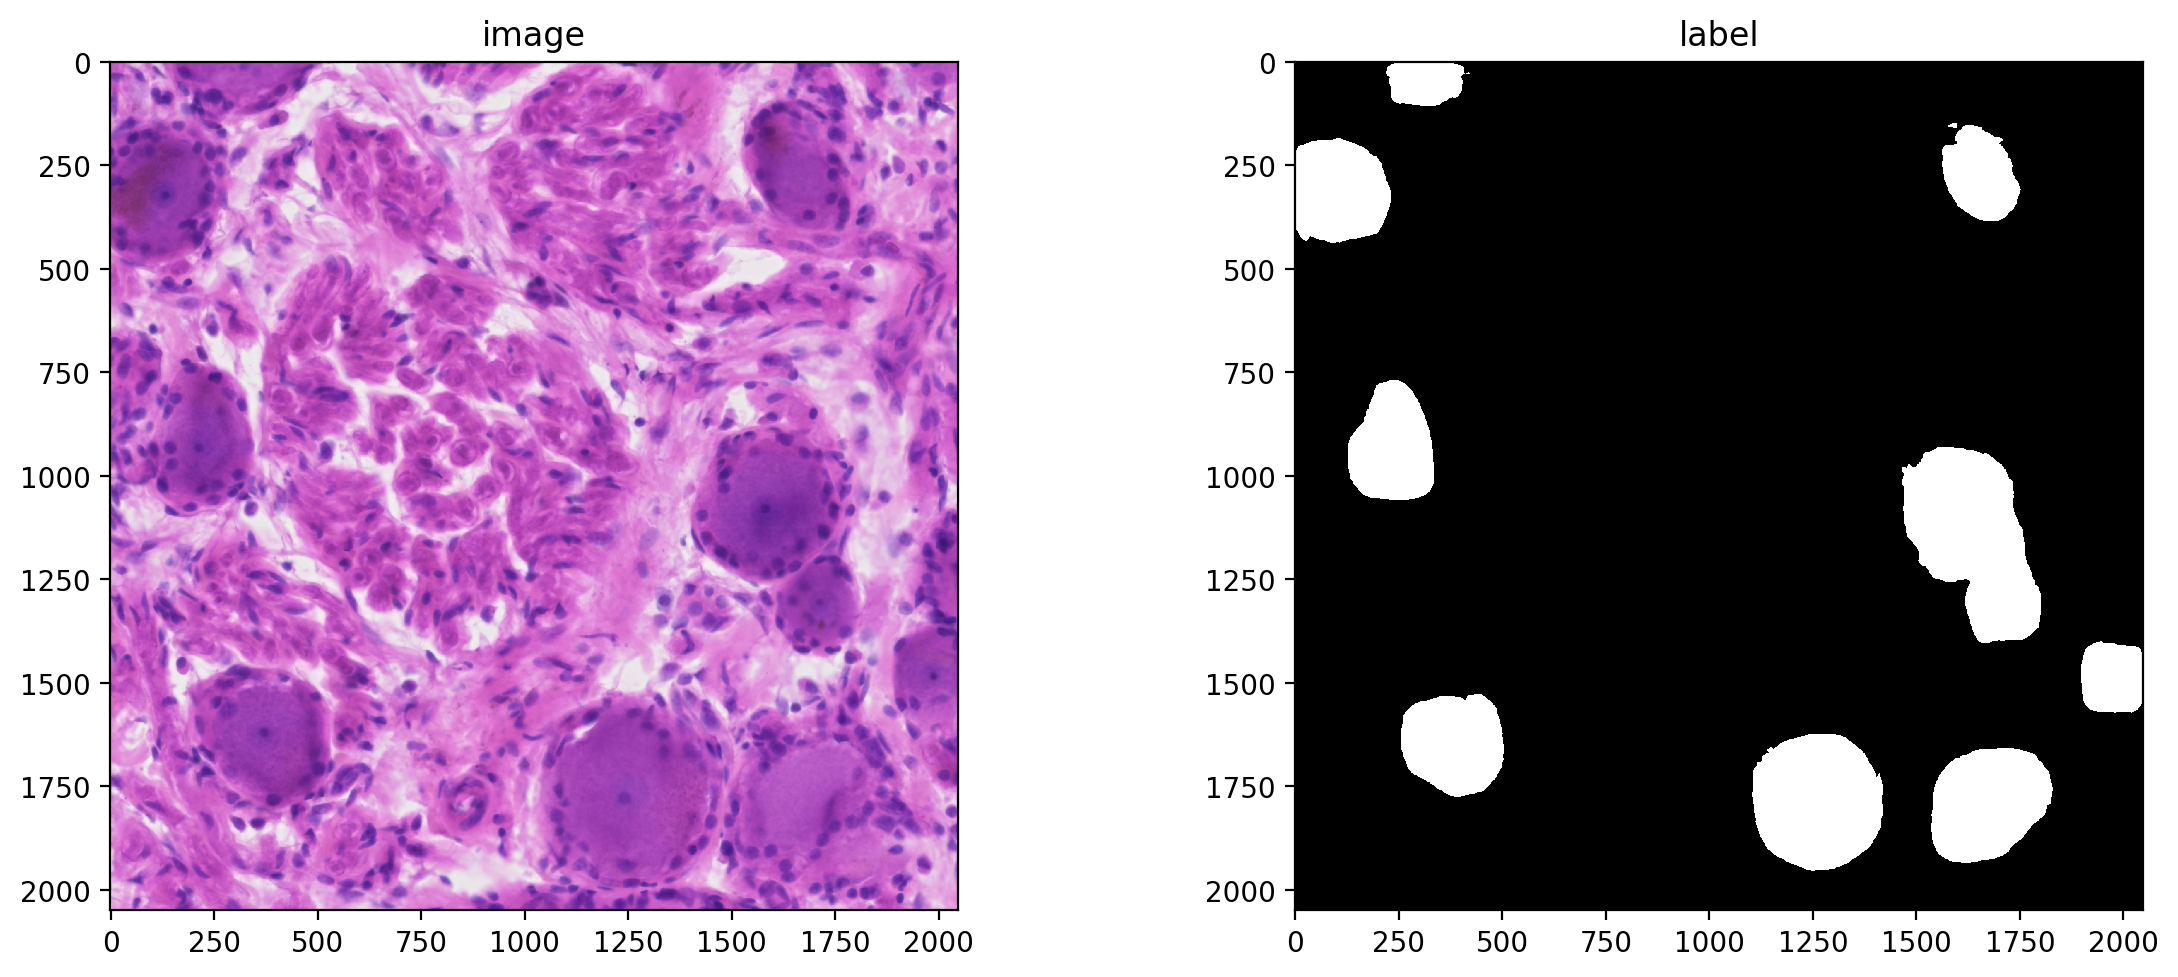

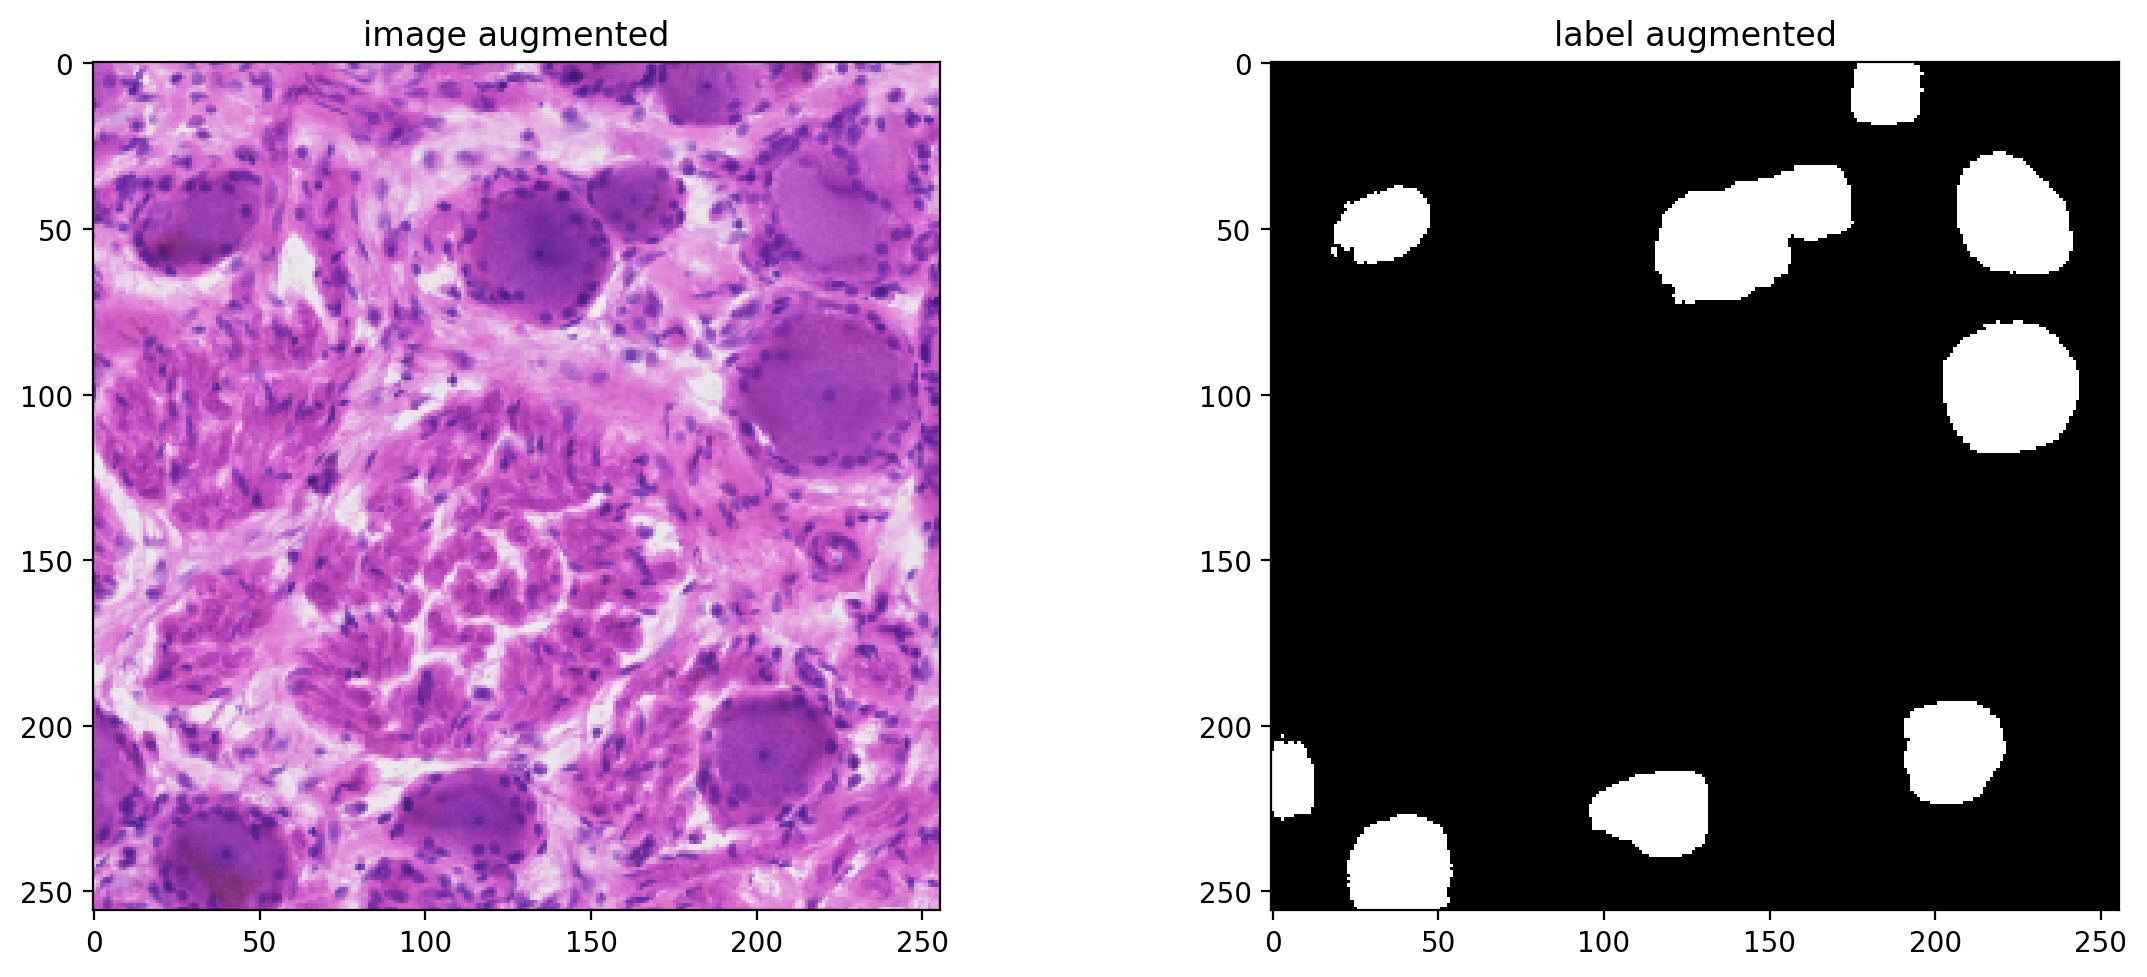

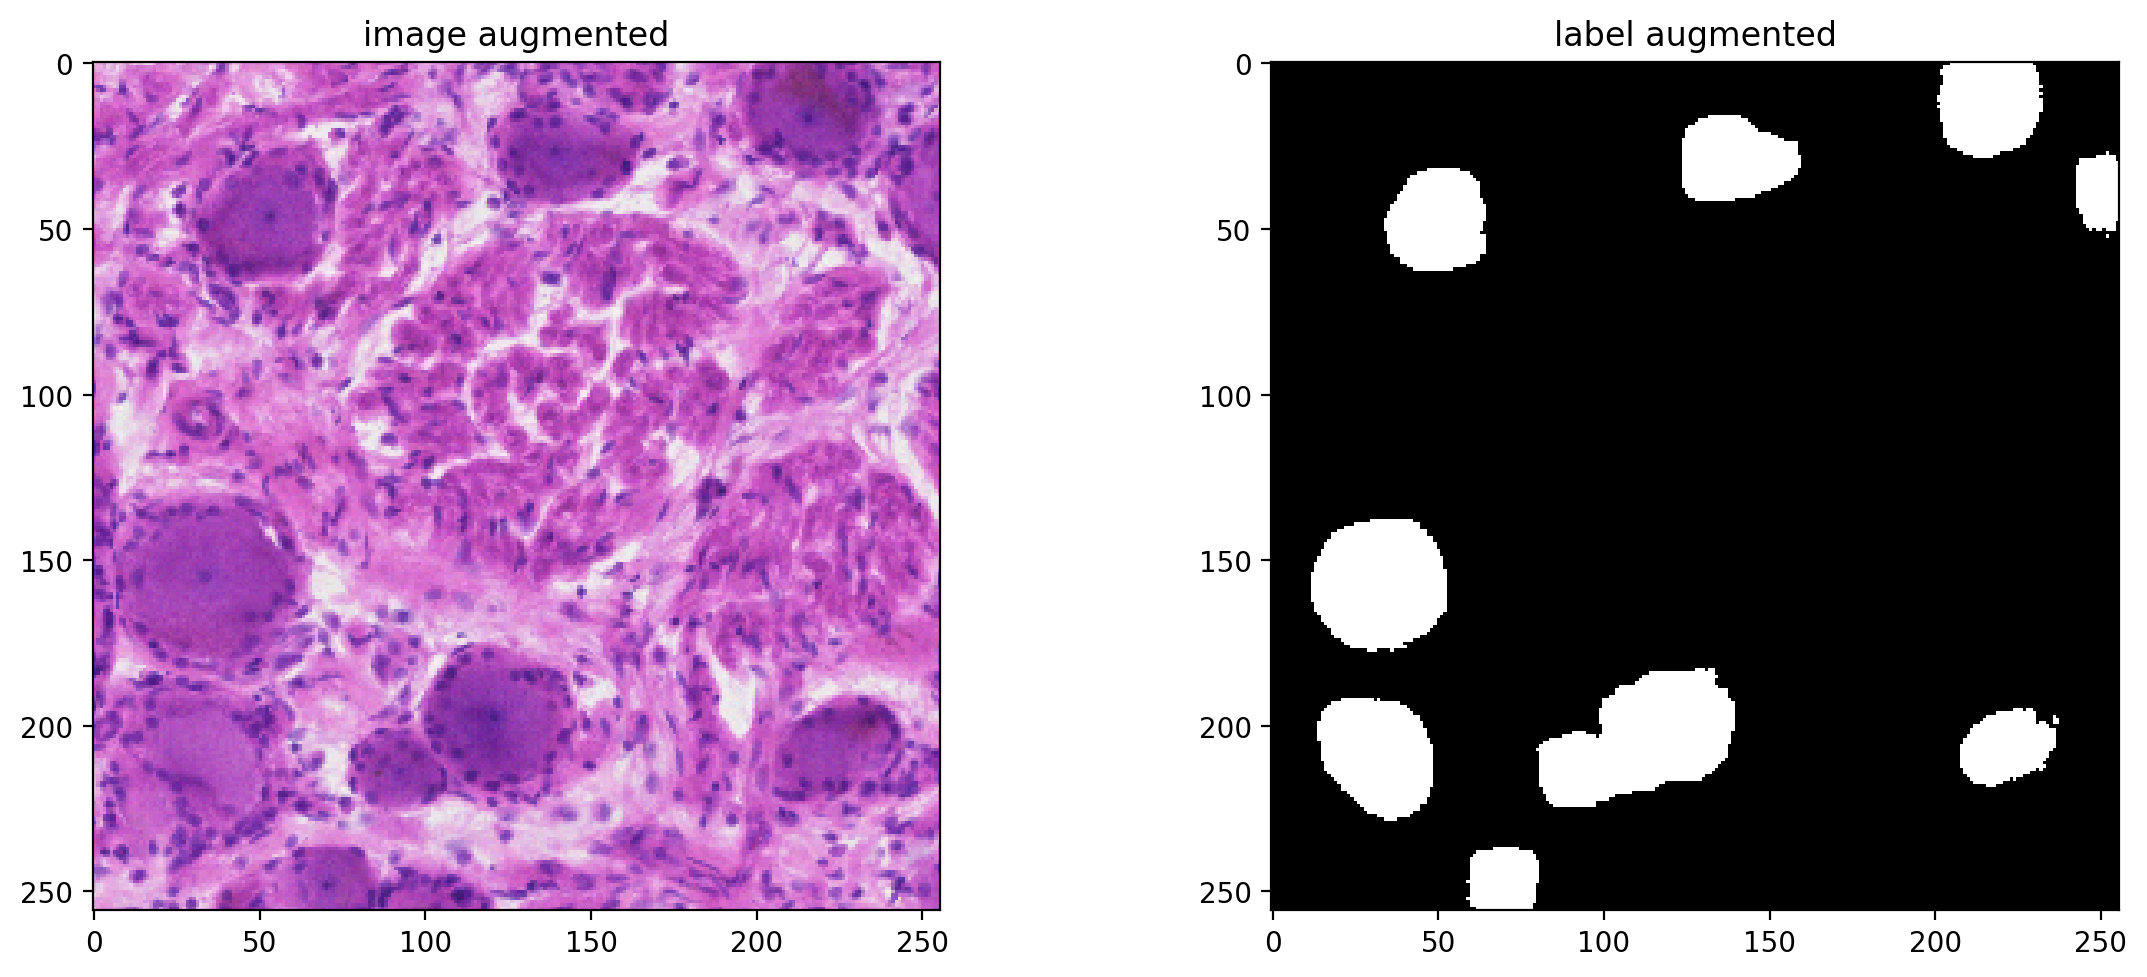

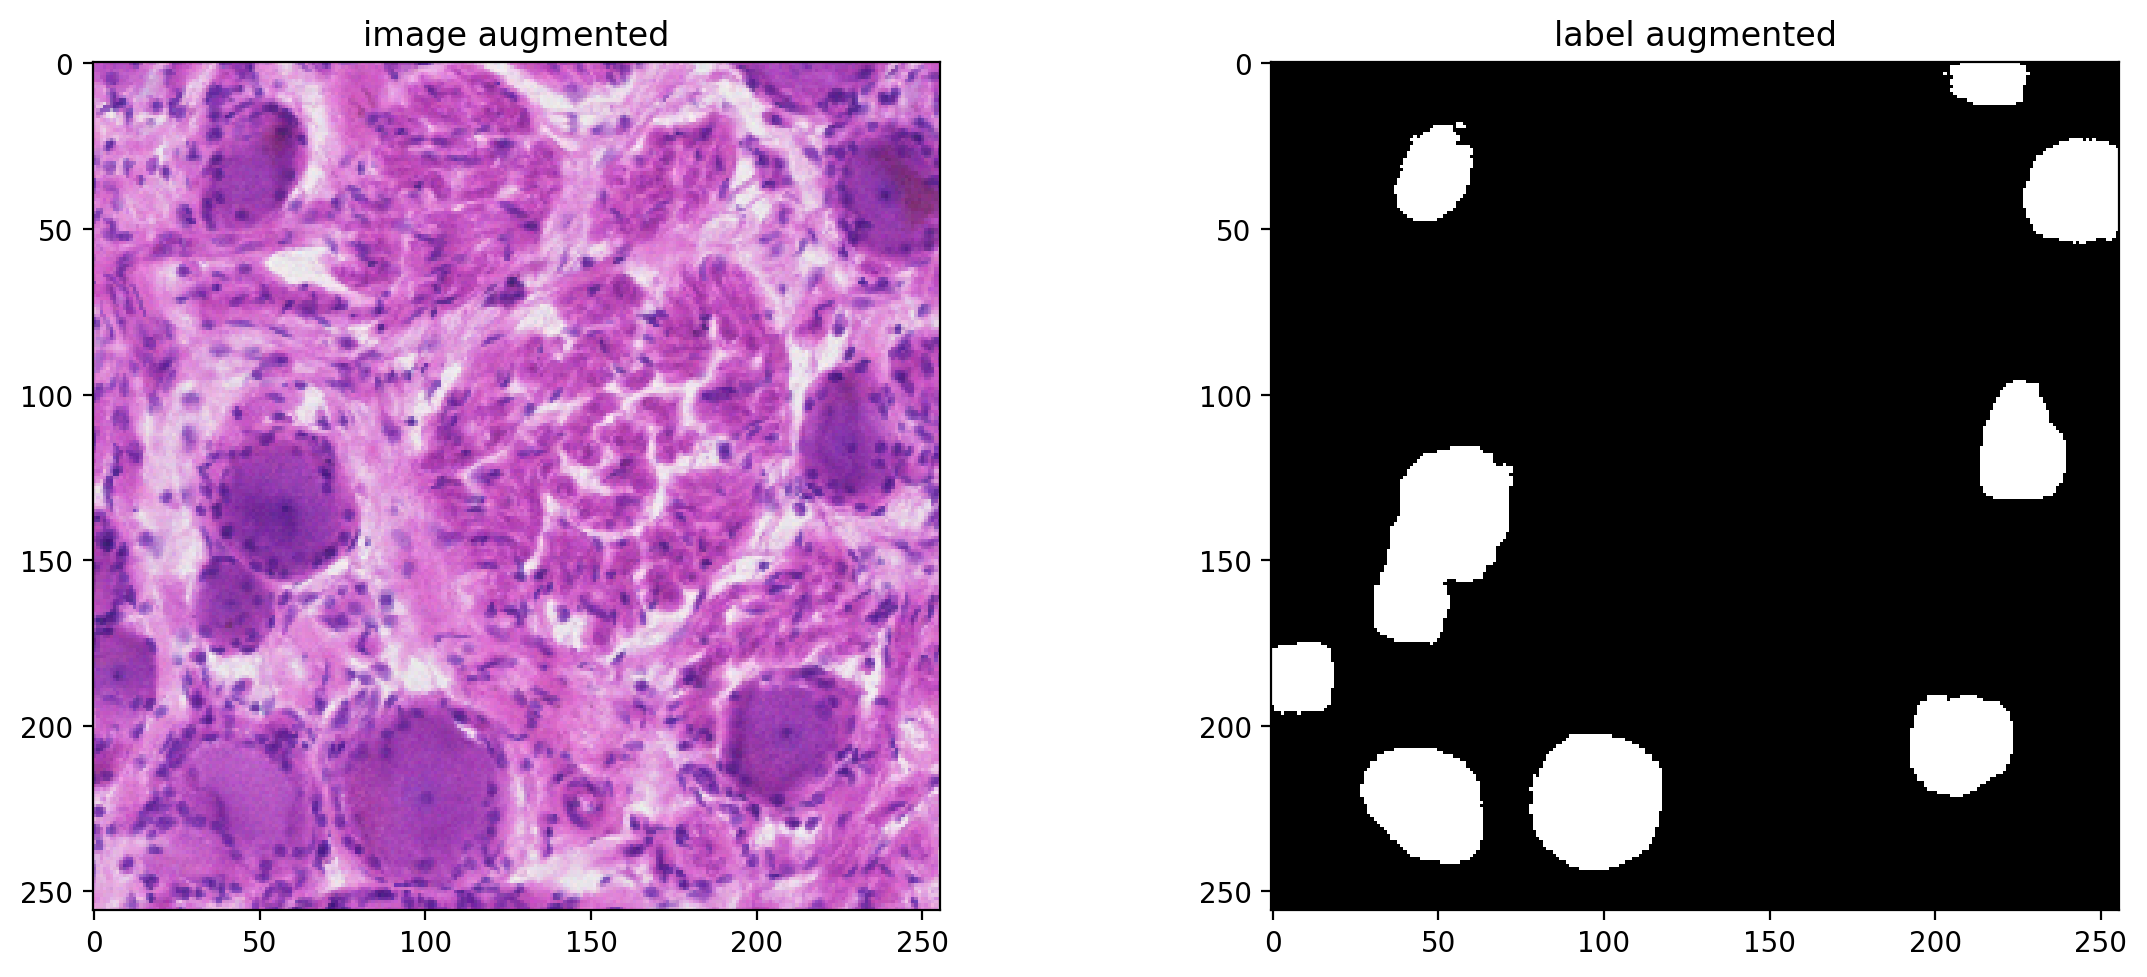

In [25]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [ ]:
model.train(X_trn, Y_trn, validation_data=(X_test,Y_test), augmenter=augmenter, epochs=50)
None;

persistent_dict.py (52): Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.


If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 315ms/step - dist_dist_iou_metric: 0.0186 - dist_loss: 61.1933 - dist_relevant_mae: 61.1927 - dist_relevant_mse: 6003.8423 - loss: 13.1845 - prob_class_loss: 0.5231 - prob_kld: 0.3312 - prob_loss: 0.4228 - val_dist_dist_iou_metric: 0.2763 - val_dist_loss: 31.3325 - val_dist_relevant_mae: 31.3258 - val_dist_relevant_mse: 1850.8192 - val_loss: 7.5970 - val_prob_class_loss: 0.4911 - val_prob_kld: 0.7674 - val_prob_loss: 0.8394 - learning_rate: 3.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - dist_dist_iou_metric: 0.2595 - dist_loss: 35.1032 - dist_relevant_mae: 35.0968 - dist_relevant_mse: 2543.7029 - loss: 8.4449 - prob_class_loss: 0.5778 - prob_kld: 0.7585 - prob_loss: 0.8465 - val_dist_dist_iou_metric: 0.3120 - val_dist_loss: 30.0758 - val_dist_relevant_mae: 30.0685 - val_dist_relevant_mse: 1696.7887 - val_loss: 6.5706 - va

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [20]:
model.optimize_thresholds(X_test, Y_test)

functional.py (237): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 1120, 1120, 3))
2025-02-08 23:50:51.700454: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-08 23:50:52.180865: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
NMS threshold = 0.5:  15%|█▌        | 3/20 [00:05<00:33,  1.99s/it, 0.908 -> 0.000]


Using optimized values: prob_thresh=0.454094, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.4540939927101135, 'nms': 0.3}

In [21]:
model.thresholds

Thresholds(prob=0.4540939927101135, nms=0.3)

# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [22]:
# help(matching)

First predict the labels for all validation images:

In [23]:
model.__dict__

{'config': Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=1, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2, 1), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.001, train_batch_size=32, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_d

In [24]:
Y_test_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_test)]

100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


Plot a GT/prediction example 

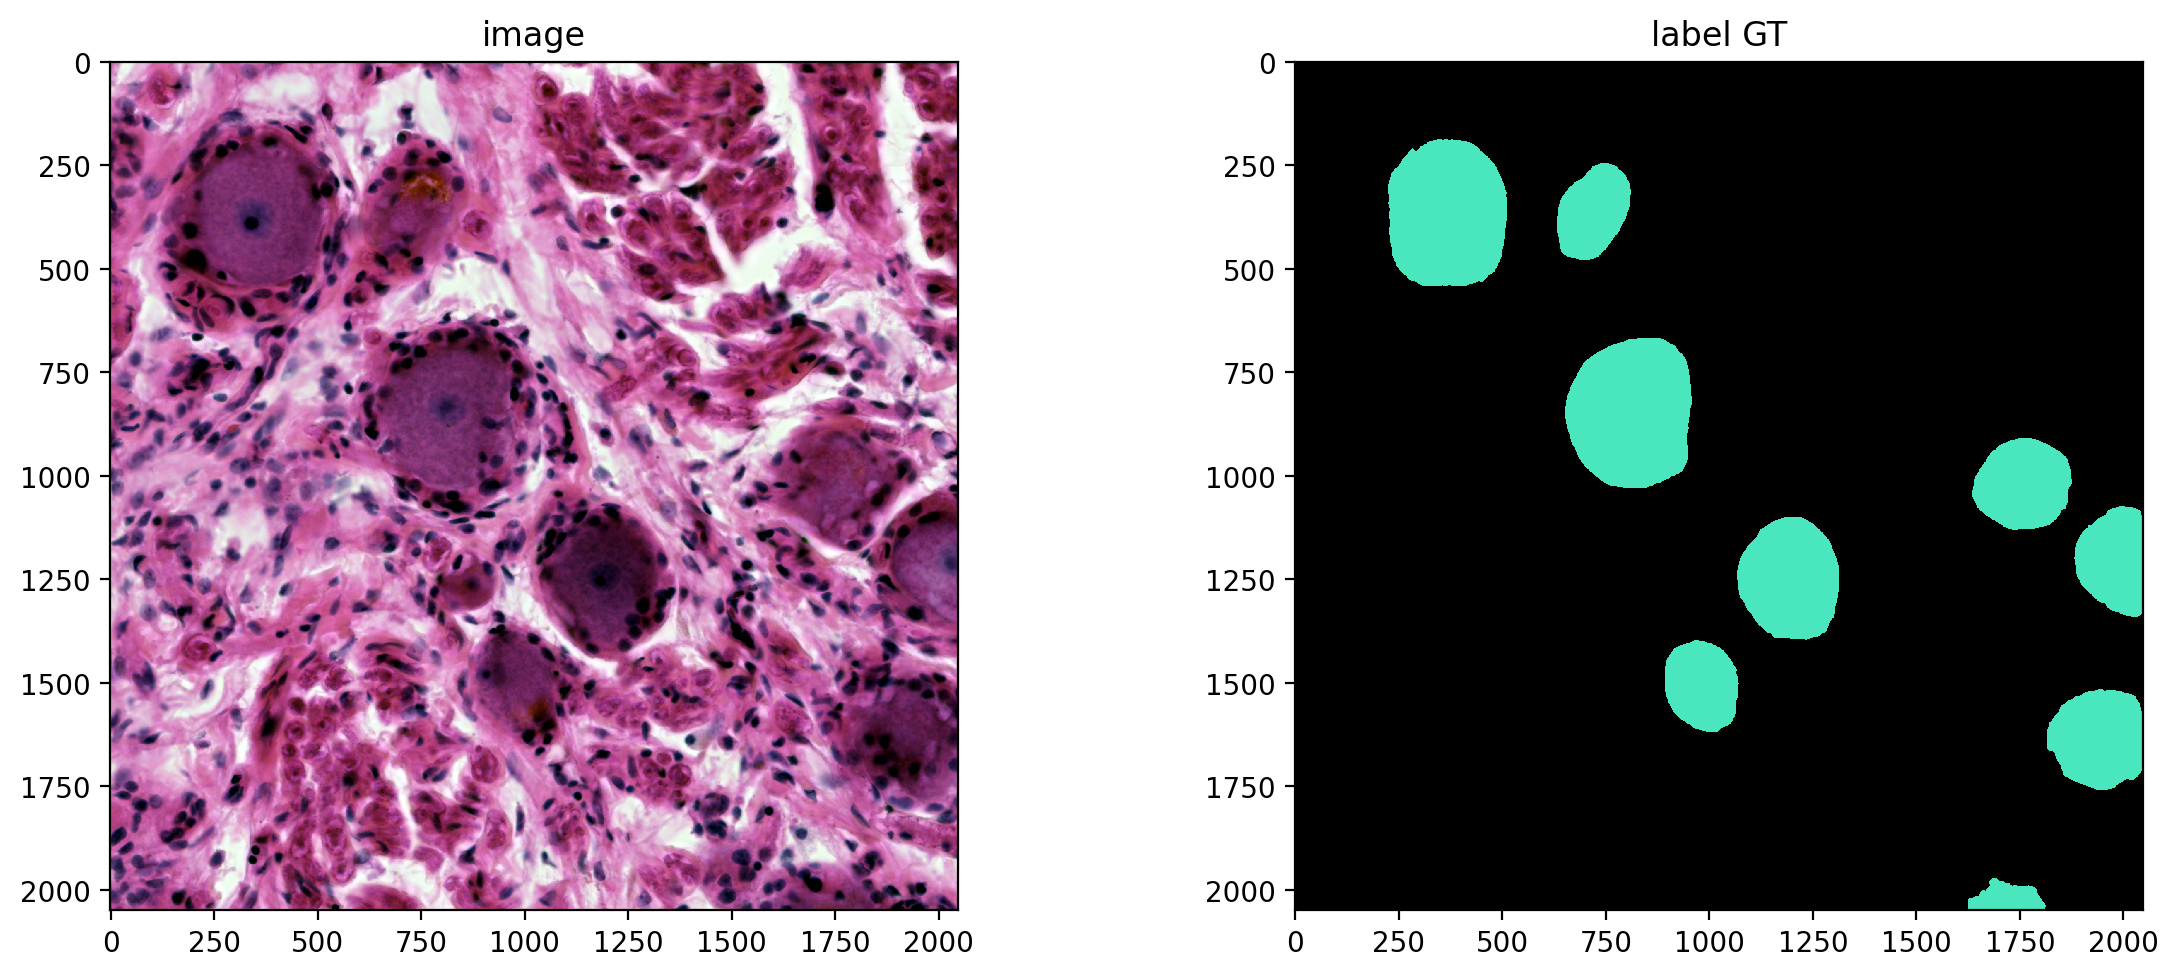

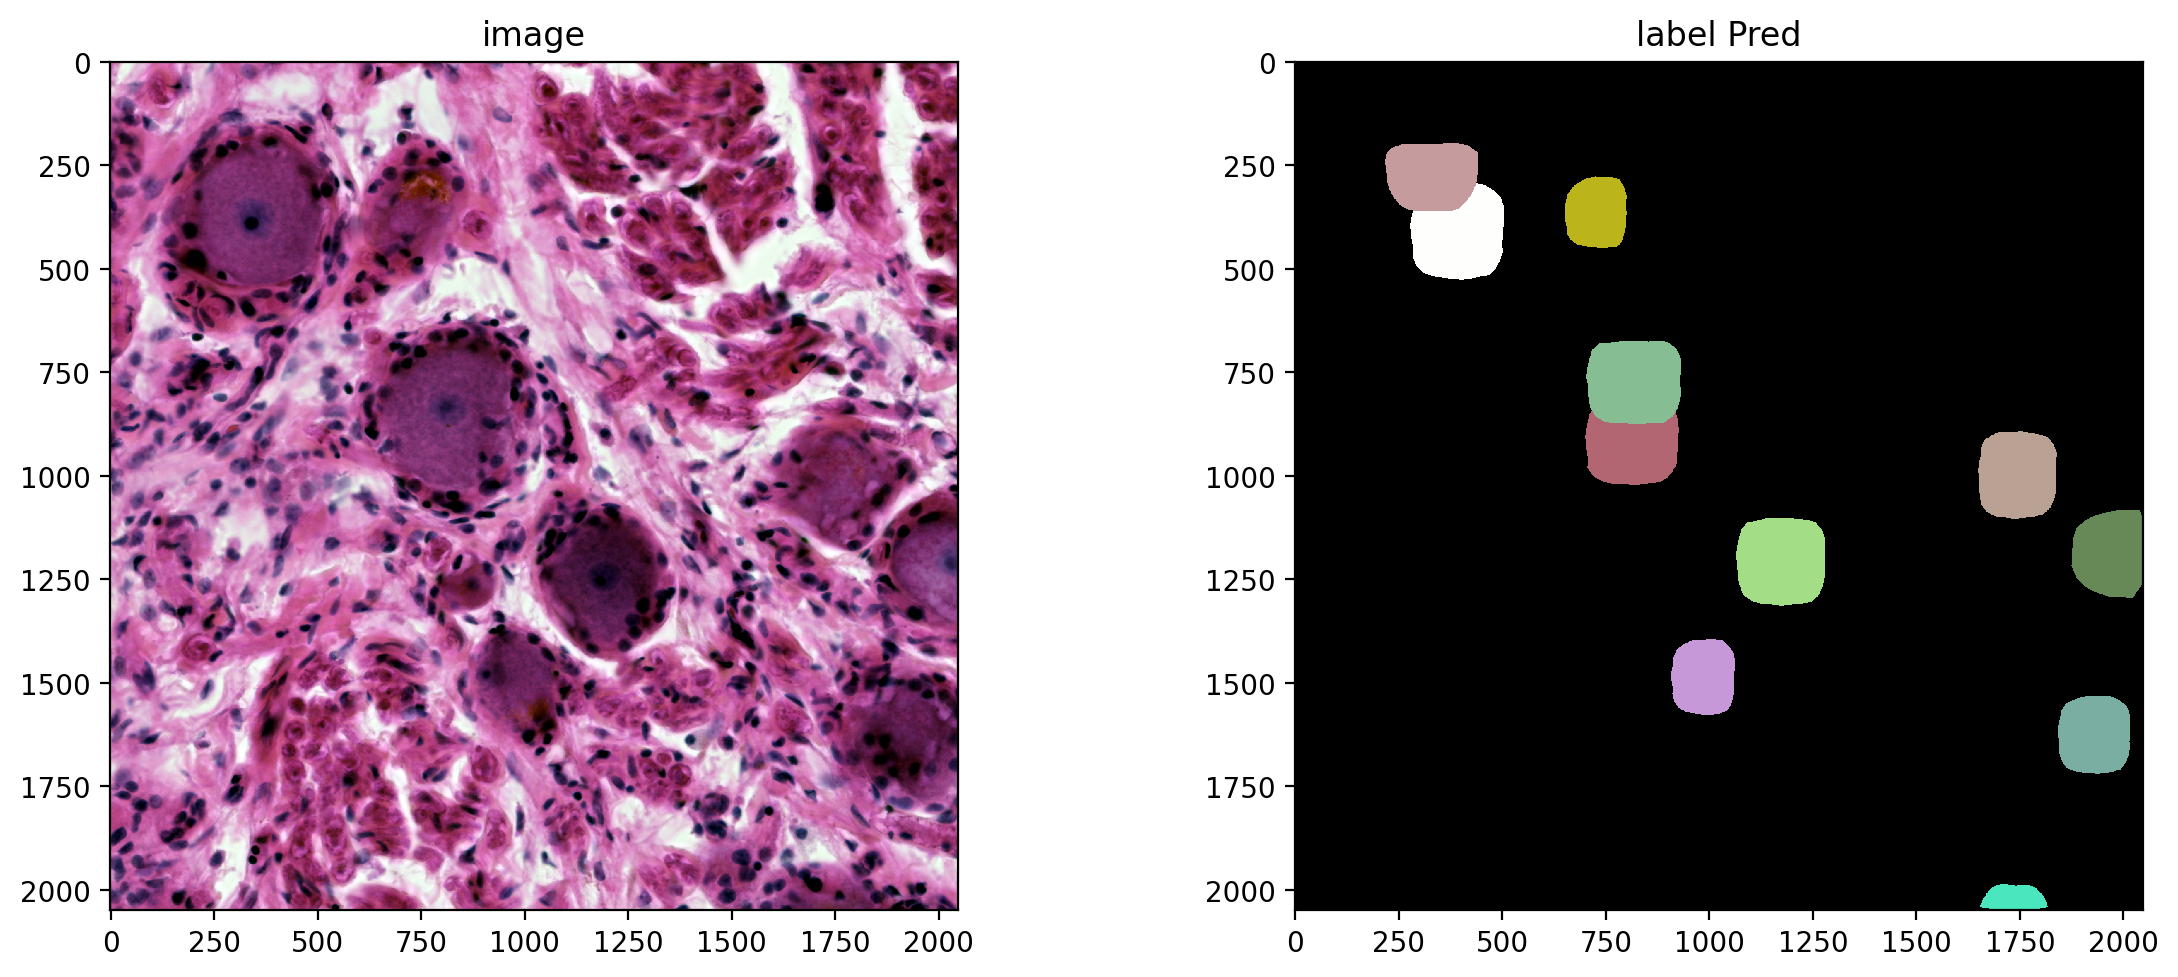

In [25]:
plot_img_label(X_test[0],Y_test[0], lbl_title="label GT")
plot_img_label(X_test[0],Y_test_pred[0], lbl_title="label Pred")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [26]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_test, Y_test_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:25<00:00,  2.82s/it]


Example: Print all available matching statistics for $\tau=0.5$

In [27]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=189, tp=0, fn=16, precision=0, recall=0, accuracy=0, f1=0, n_true=16, n_pred=189, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

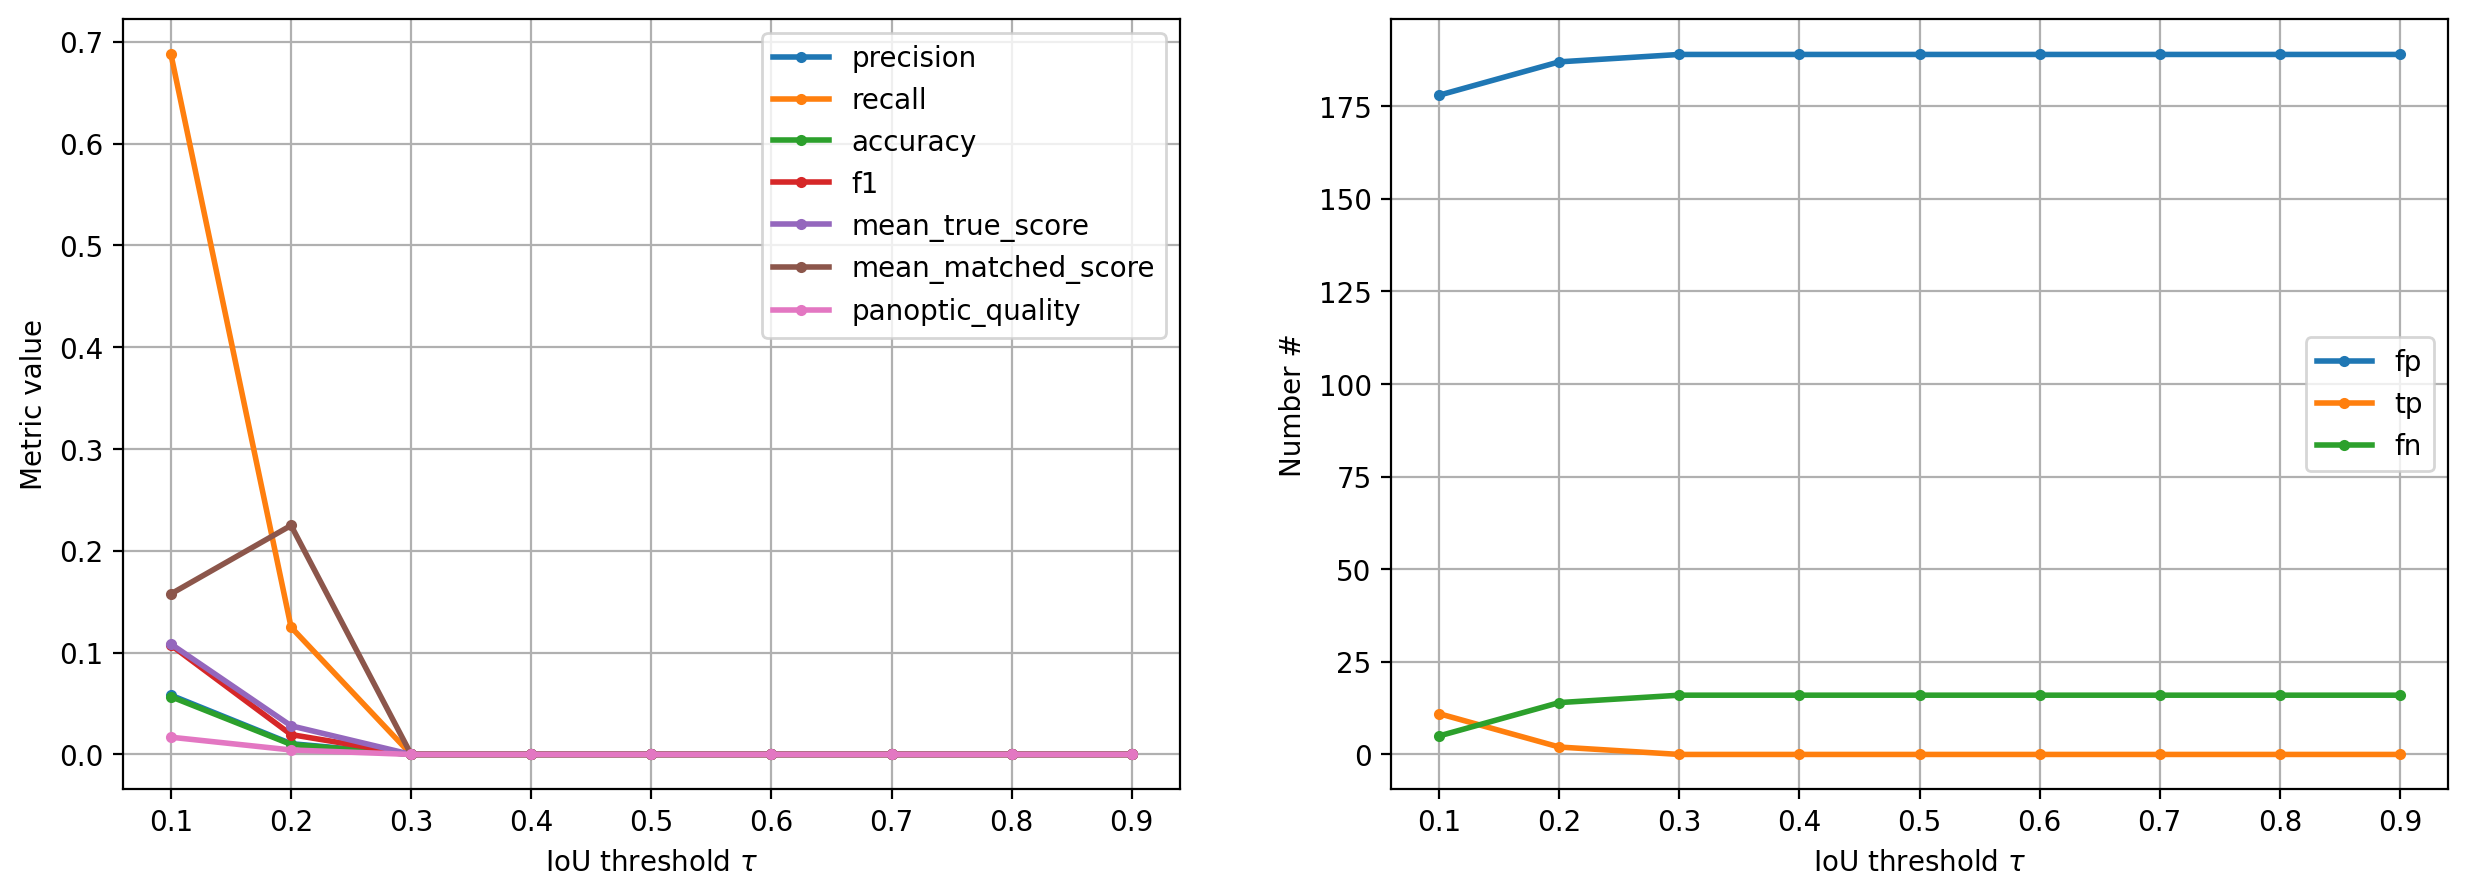

In [28]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();